# Word Embeddings

## Loading Imdb dataset

In [1]:
import tensorflow_datasets as tfds

imdb, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)

/Users/future/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Taking random examples from dataset

In [4]:
random_example = imdb['train'].take(1)
print(random_example)
print(type(random_example))

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<class 'tensorflow.python.data.ops.take_op._TakeDataset'>


## Data Preprocessing

In [5]:
import tensorflow as tf
import numpy as np

training_data = []
training_labels = []

test_data = []
test_labels = []

for data, label in imdb['train']:
    training_data.append(data.numpy().decode('utf8'))
    training_labels.append(label.numpy())

for data, label in imdb['test']:
    test_data.append(data.numpy().decode('utf8'))
    test_labels.append(label.numpy())

training_data = np.array(training_data)
training_labels = np.array(training_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

Dataset Length

In [7]:
print('Training size', len(training_data))
print('Testing size', len(test_data))

Training size 25000
Testing size 25000


### Tokenize

Hyperparameters

In [69]:
dict_size = 8192
sentence_max_length = 128
epochs = 10
oov_tok = '<OOV>'
embed_size = 16

In [70]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=dict_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_data)

print('No. of unique words in corpus',len(tokenizer.word_index.keys()))

No. of unique words in corpus 88583


In [71]:
training_sequences = tokenizer.texts_to_sequences(training_data)
training_sequences = pad_sequences(training_sequences, padding='post', truncating='post', maxlen=sentence_max_length)

test_sequences = tokenizer.texts_to_sequences(test_data)
test_sequences = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=sentence_max_length)

Picking random encoded sequence

In [72]:
from random import randint
rand_idx = randint(0, len(training_sequences))

rand_sequence = training_sequences[rand_idx]
print(rand_sequence)

print('Decoded sequence', tokenizer.sequences_to_texts([rand_sequence]))
print('Original sentence', training_data[rand_idx])

[  11   14  281    6   59 2894   16  441 3627    3 1565 3736   11  294
    2  434   20   17   59  221    3   47  367   11   26   55  324   49
    2   18   14   42  101   74 3771   73   30 4734   13   12   14   22
   29    5   66  126 2048    8    8   10  150 3262  293   53   71   10
    7   97 5301    3   48    7  115  210   11  242  683   10   98   26
   75   74  126    8    8   11 4475 1921    6   65   12   20  446   21
    2 7939 3622    8    8   90  436  127  276  892   23   24    4    1
    3   41  179    6   65   30    5  441    1    3 1565    1  106    8
    8   10   14    4  337   94    6 1139   33 2194    0    0    0    0
    0    0]
Decoded sequence ["i was true to my regard for mr glover and ms goldberg i watched the entire film with my family and some friends i have no idea what the movie was about after much discussion we all agreed that this was not one of their better efforts br br it doesn't hang together very well it is too choppy and there is little comedy i am disapp

## Model Creation

In [73]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(dict_size, embed_size, input_length=sentence_max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 embedding_9 (Embedding)     (None, 128, 16)           131072    
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 4)                 8196      
                                                                 
 dense_15 (Dense)            (None, 1)                 5         
                                                                 
Total params: 139273 (544.04 KB)
Trainable params: 139273 (544.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [75]:
hist_data = model.fit(training_sequences, training_labels,validation_data=(test_sequences, test_labels), epochs=epochs)

Epoch 1/10
782/782 [==============================] - 1s 1ms/step - loss: 0.5070 - accuracy: 0.7272 - val_loss: 0.3758 - val_accuracy: 0.8318
Epoch 2/10
782/782 [==============================] - 1s 1ms/step - loss: 0.2608 - accuracy: 0.8966 - val_loss: 0.3907 - val_accuracy: 0.8280
Epoch 3/10
782/782 [==============================] - 1s 1ms/step - loss: 0.1369 - accuracy: 0.9589 - val_loss: 0.4567 - val_accuracy: 0.8156
Epoch 4/10
782/782 [==============================] - 1s 2ms/step - loss: 0.0484 - accuracy: 0.9920 - val_loss: 0.5351 - val_accuracy: 0.8164
Epoch 5/10
782/782 [==============================] - 1s 1ms/step - loss: 0.0152 - accuracy: 0.9982 - val_loss: 0.6188 - val_accuracy: 0.8126
Epoch 6/10
782/782 [==============================] - 1s 1ms/step - loss: 0.0047 - accuracy: 0.9998 - val_loss: 0.6876 - val_accuracy: 0.8134
Epoch 7/10
782/782 [==============================] - 1s 1ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.7507 - val_accuracy: 0.8139
Epoch 

## Plotting accuracies

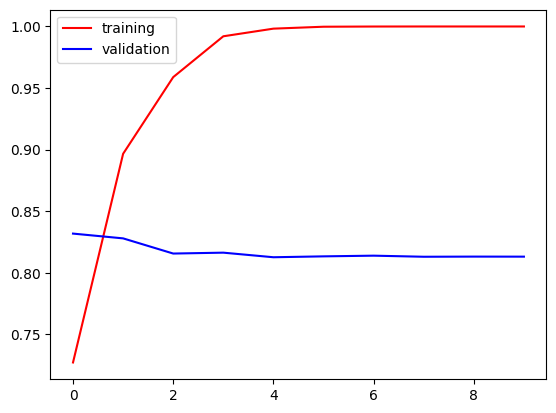

In [76]:
import matplotlib.pyplot as plt

plt.plot(hist_data.history['accuracy'], 'r', label='training')
plt.plot(hist_data.history['val_accuracy'], 'b', label='validation')
plt.legend()
plt.show()

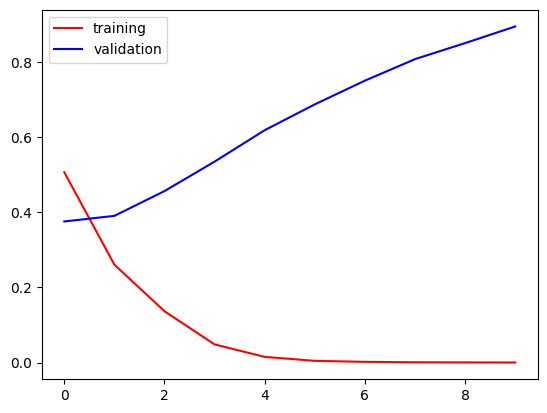

In [77]:
plt.plot(hist_data.history['loss'], 'r', label='training')
plt.plot(hist_data.history['val_loss'], 'b', label='validation')
plt.legend()
plt.show()

## Getting data for visualization

Get weights of embedding layer

In [88]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.weights
print(embedding_weights[0].shape)

random_layer = embedding_weights[0][randint(0,dict_size)]
print(random_layer)

(8192, 16)
tf.Tensor(
[ 0.05144861 -0.08108908  0.07988457  0.12564093  0.07911893  0.03508922
  0.00882807 -0.01759071 -0.07769845 -0.02029196 -0.072363   -0.06455746
  0.05826717 -0.01975162 -0.12883754  0.05164154], shape=(16,), dtype=float32)


For visualization, you just have to write each 16 dimensional vector corresponding to each word in the dictionary

In [100]:
embeddings = embedding_weights[0]

with open('./week2/meta_custom.tsv', 'w') as meta:
    with open('./week2/vectors_custom.tsv', 'w') as vecs:
        for word_index in range(1, dict_size):
            word = tokenizer.index_word[word_index]
            embed = embeddings[word_index].numpy()
            meta.write(word+"\n")
            vecs.write("\t".join([str(x) for x in embed])+"\n")



In [97]:
[i for i in embeddings[0].numpy()]

[-0.019889446,
 -0.083820015,
 -0.013681579,
 -0.011155984,
 -0.03354986,
 0.03748888,
 -0.049301866,
 -0.023679575,
 -0.03697345,
 -0.04205737,
 0.0009301033,
 -0.016190518,
 0.05027788,
 -0.07147403,
 -0.012077646,
 -0.05253376]